
# Module 2: Optimized Fraud Detection Model Training

In [1]:
import os
os.chdir("..")
print(os.getcwd())

/Users/matildamwendwa/Desktop/Desktop - Admin’s MacBook Pro/Python_Projects/fed-fraud-detection


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (average_precision_score, f1_score, 
                             roc_auc_score, confusion_matrix, 
                             precision_recall_curve, roc_curve)
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
def plot_metrics(y_true, y_pred, y_probs, title_suffix=""):
    """Visualize model performance metrics."""
    plt.figure(figsize=(15, 10))
    
    # Confusion Matrix
    plt.subplot(2, 2, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Fraud', 'Fraud'], 
                yticklabels=['Not Fraud', 'Fraud'])
    plt.title(f'Confusion Matrix {title_suffix}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # ROC Curve
    plt.subplot(2, 2, 2)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve {title_suffix}')
    
    # Precision-Recall Curve
    plt.subplot(2, 2, 3)
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve {title_suffix}')
    
    # Class Distribution
    plt.subplot(2, 2, 4)
    y_true.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title(f'Class Distribution {title_suffix}')
    plt.xticks([0, 1], ['Not Fraud', 'Fraud'], rotation=0)
    
    plt.tight_layout()
    plt.show()


In [45]:
def find_best_threshold(y_true, y_probs):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    best_idx = np.argmax(f1_scores)
    return thresholds[best_idx], f1_scores[best_idx]


=== Threshold Tuning ===
Optimal Threshold: 0.2363
Best F1 at threshold: 0.9412

=== Best Model ===
WeightedEnsemble_L2 (Score: 0.9931)

=== Validation Metrics ===
AUPRC: 0.9823
ROC-AUC: 0.9760
F1 (threshold=0.24): 0.9412


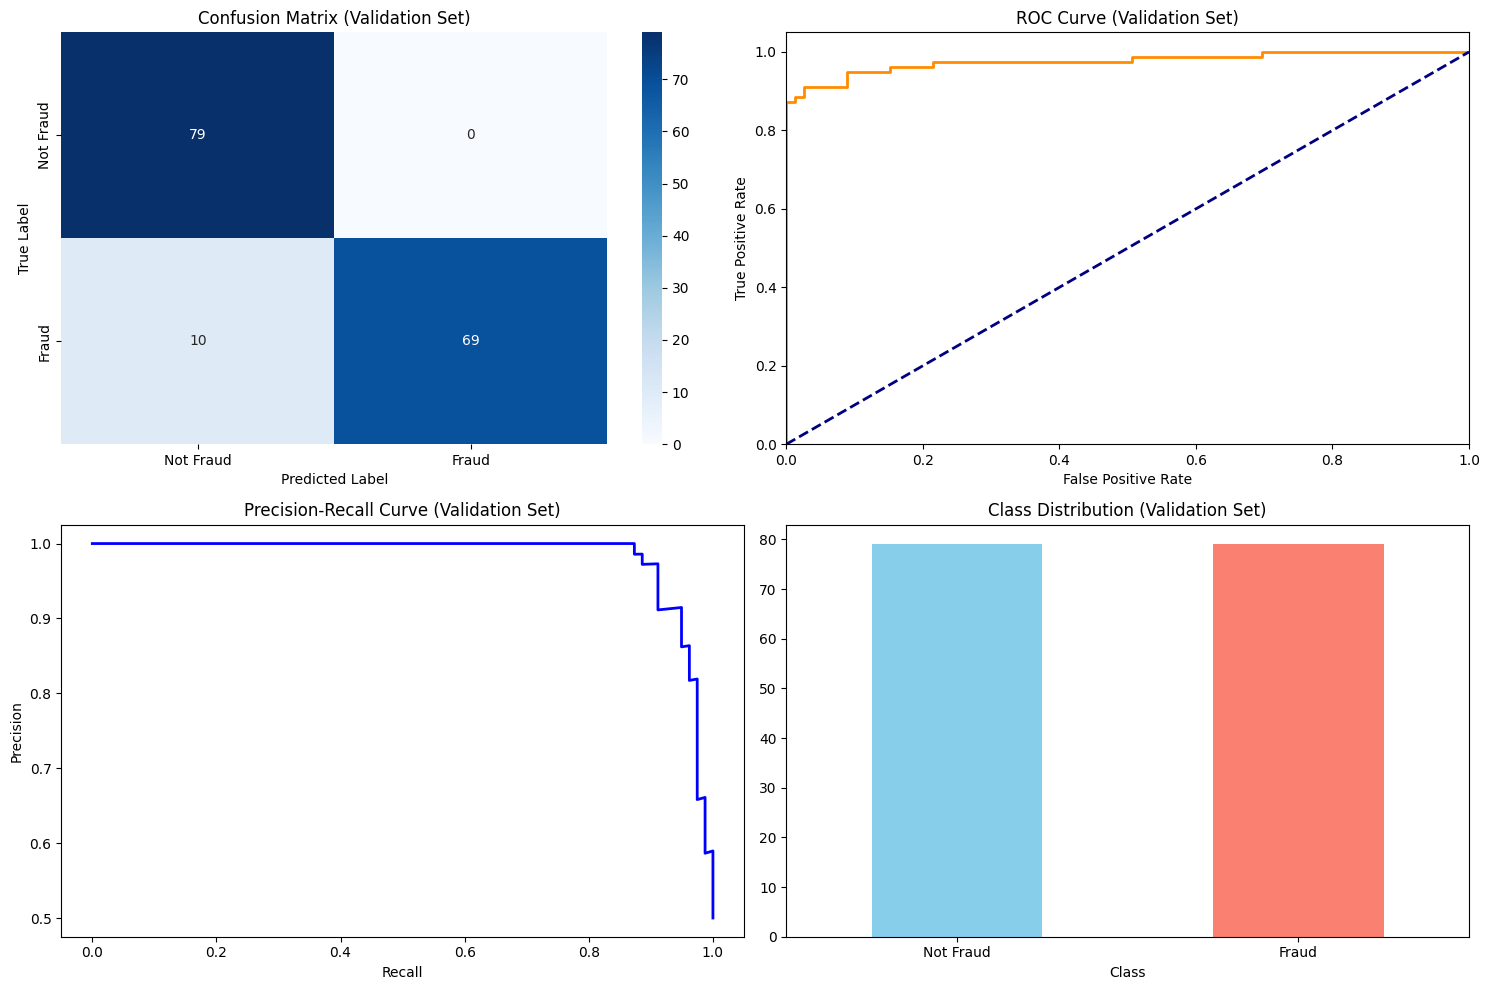

In [67]:
def run_autogluon_train_val():
    # 1. Load Dataset 
    X = pd.read_parquet("data/preprocess/X_train.parquet")
    y = pd.read_parquet("data/preprocess/y_train.parquet").squeeze()

    # 2. Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, 
        test_size=0.2, 
        stratify=y,
        random_state=42
    )

    train_data = pd.concat([X_train, y_train.rename("Class")], axis=1)
    val_data = pd.concat([X_val, y_val.rename("Class")], axis=1)

    # 3. Train model with optimized settings
    predictor = TabularPredictor(
        label='Class',
        eval_metric='average_precision',  # Primary metric for fraud detection
        problem_type='binary',
        path='models/autogluon_models'
    ).fit(
        train_data=train_data,
        # tuning_data=val_data,  # Use validation data for early stopping
        presets='optimize_for_deployment',  # Use best quality preset
        # presets='best_quality',  # Use best quality preset
        time_limit=3600,
        save_space=True,
        hyperparameters={
            'GBM': {
                'num_boost_round': 200,
                'learning_rate': 0.05,
                'feature_fraction': 0.8
            },
            'CAT': {
                'iterations': 300,
                'learning_rate': 0.05,
                'depth': 8
            },
            'XGB': {
                'n_estimators': 150,
                'learning_rate': 0.1,
                'max_depth': 6,
                'subsample': 0.9
            },
            'NN_TORCH': {
                'num_epochs': 50,
                'optimizer': 'adamw',
                'learning_rate': 1e-3,  
                'weight_decay': 1e-3,
                'activation': 'relu',
                # 'layers': [256, 128, 64],  
                'dropout_prob': 0.3,
                'batch_size': 256,
                # 'use_batchnorm': True,  # batch normalization
                # 'max_batch_size': 512  # safety cap
            },
            'RF': {
                'n_estimators': 200,
                'max_depth': 15,
                'max_features': 'sqrt'
            }
        },
        ag_args_fit={'class_weights': 'balanced'},
        verbosity=0,
    )

    y_pred = predictor.predict(X_val)
    y_probs = predictor.predict_proba(X_val)[1]
    best_threshold, best_f1 = find_best_threshold(y_val, y_probs)
    y_pred_thresh = (y_probs >= best_threshold).astype(int)

    print(f"\n=== Threshold Tuning ===")
    print(f"Optimal Threshold: {best_threshold:.4f}")
    print(f"Best F1 at threshold: {best_f1:.4f}")

    predictor.optimal_threshold = best_threshold

    leaderboard = predictor.leaderboard(silent=True)

    print("\n=== Best Model ===")
    best_model = leaderboard.iloc[0]['model']
    best_model_score = leaderboard.iloc[0]['score_val']
    print(f"{best_model} (Score: {best_model_score:.4f})")

    # SAVING THE BEST MODEL
    predictor.delete_models(
        models_to_keep=[best_model],
        dry_run=False,  # Set to True first to verify
    )

    print("\n=== Validation Metrics ===")
    print(f"AUPRC: {average_precision_score(y_val, y_probs):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_val, y_probs):.4f}")
    print(f"F1 (threshold={best_threshold:.2f}): {f1_score(y_val, y_pred_thresh):.4f}")
    
    # Visualization
    plot_metrics(y_val, y_pred, y_probs, "(Validation Set)")
  
    return predictor

model= run_autogluon_train_val()


=== Test Set Metrics ===
AUPRC: 0.6206
ROC-AUC: 0.9772
F1: 0.0536


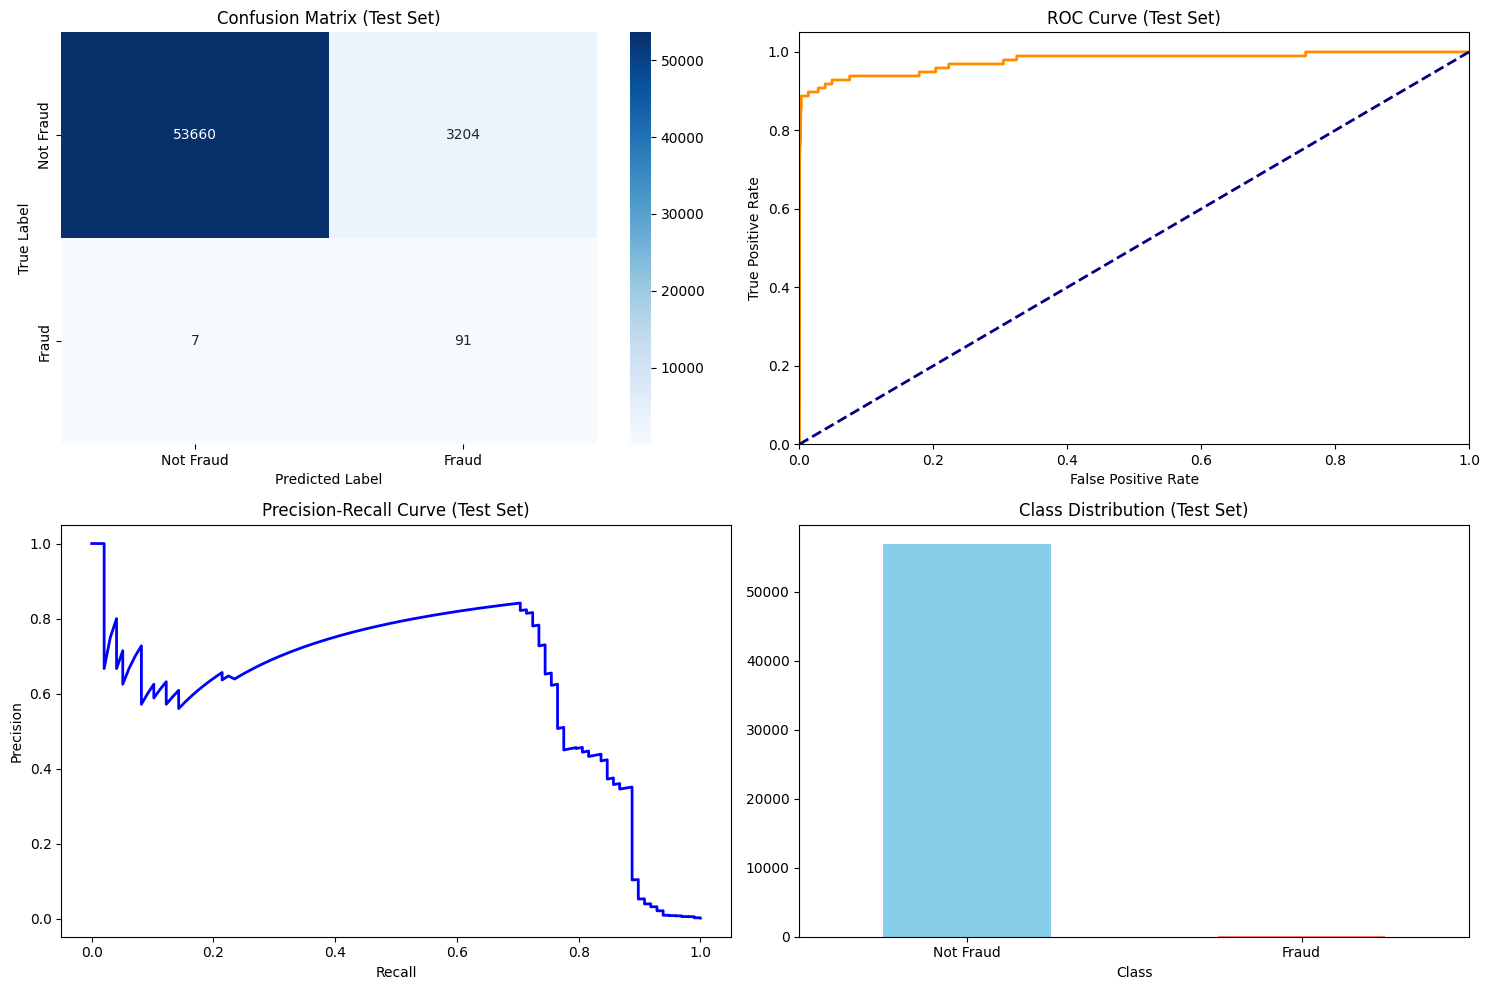

In [68]:
def test_predictions(predictor, test_data_path="data/preprocess"):
    """Evaluate model performance on test set."""
    try:
        X_test = pd.read_parquet(f"{test_data_path}/X_test.parquet")
        y_test = pd.read_parquet(f"{test_data_path}/y_test.parquet").squeeze()
        
        y_probs = predictor.predict_proba(X_test)[1]

        best_threshold = getattr(predictor, 'optimal_threshold', 0.5) 
        y_pred_best= (y_probs >= best_threshold).astype(int)


        print("\n=== Test Set Metrics ===")
        print(f"AUPRC: {average_precision_score(y_test, y_probs):.4f}")
        print(f"ROC-AUC: {roc_auc_score(y_test, y_probs):.4f}")
        print(f"F1: {f1_score(y_test, y_pred_best):.4f}")
        
        # Visualization
        plot_metrics(y_test, y_pred_best, y_probs, "(Test Set)")
        
        return y_pred_best, y_probs
    except Exception as e:
        print(f"Error loading test data: {e}")
        return None, None
    
test_preds, test_probs = test_predictions(model)